# Human-in-the-Loop AI Defect Classification: Test
Testing Snapshot Ensemble

Five snapshot models were saved in "training.ipynb" for ensemble prediction. 25% of classified data was separated from training data before training, and will be used below of final testing.

Note: It is important that this step is **not iterated on**. This will bias the model to overfit, and won't be a good representation of generalizability. Once test data is exposed should be considered "point of no return" in terms of model's architecture, parameters, and hyperparameters.

In [1]:
import os
import re
import pickle
import gc

import numpy as np
import tensorflow as tf

import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from PIL import Image

from keras import regularizers, optimizers 
from keras import backend as K

from keras.backend.tensorflow_backend import set_session, clear_session, get_session
from keras.callbacks import Callback
from keras.layers import (Flatten, Activation, Dense, Dropout, BatchNormalization,
                          Conv2D, MaxPooling2D)
from keras.models import Sequential, load_model

from keras_preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import *
from CLR.clr_callback import *

%matplotlib inline

TESTFILES_PATH = os.path.join(os.getcwd(), '..', 'testing_files')
CONFIG_PATH = os.path.join(TESTFILES_PATH, 'conf.ini')
DATA_PATH = os.path.join(os.getcwd(), '..', 'raw_data')
OUTPUT_PATH = os.path.join(os.getcwd(), '..', 'cleaned_data')
LOT_ROOT = os.path.join('..', 'raw_data', 'l0Q119TeOS12PostHF')

Using TensorFlow backend.


Changing backend to theano for test engine.

In [2]:
os.environ['KERAS_BACKEND'] = 'theano'

In [3]:
def reset_keras(semnet_instance=None):
    K.clear_session()

    sess = tf.Session()

    K.set_session(sess)
    try:
        del semnet_instance.model
    except:
        pass

    print(gc.collect())

def load_models(files):
    """
    Utility to load .h5 files of trained models
    
    input
    -----
    files, list or tuple
        paths to saved models
        
    output
    -----
    list of keras model objects
    """
    models = []
    for file in files:
        model = load_model(file)
        models.append(model)
    return models

def drop_broken_paths(df):
    """
    Utility to drop values with broken filepaths
    
    input
    -----
    df: pandas dataframe object
        - needs column 'image_paths'
        
    output
    -----
    pandas dataframe
    """
    valid_filenames_mask = df['image_paths'].apply(os.path.exists).values
    return df[valid_filenames_mask]

Loading data...

In [4]:
test_file = os.path.join(TESTFILES_PATH, 'test-HD.csv')
test_df = drop_broken_paths(pd.read_csv(test_file))

# Dropping values with broken filenames
valid_filenames_mask = test_df['image_paths'].apply(os.path.exists).values

# Dropping examples to n=1140 for even batch size 
X_test = test_df.copy()[valid_filenames_mask][:1140]

y_encoder = LabelEncoder()
y_test = X_test['defect_type'].copy()
y_test_enc = y_encoder.fit_transform(y_test)

In [5]:
X_test.head()

,Unnamed: 0,Unnamed: 0.1,level_0,index,def_num,x,y,defect,defect_label,lot,slot,wafer_id,defect_id,image_paths,image_type,defect_type,protrusion,scratch,particle
0,0,0,0,0,513,79913,-123603,True,Chatter Mark,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-513,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
1,44,44,11,11,8,-4388,-12804,False,No Defect,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-8,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,No Defect,False,False,False
2,52,52,12,12,54,-22803,25512,True,Chatter Mark,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-54,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Scratch,False,True,False
3,60,60,14,14,61,-35169,618,True,Protruding Line,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-61,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Protrusion,True,False,False
4,64,64,15,15,65,-15752,31968,True,Protruding Line,l0Q119TeOS11PostHF,3,2478B211-812D-41BE-A394-260C78C13121,2478B211-812D-41BE-A394-260C78C13121-65,D:\sem_crawl\labeled_data\l0Q119TeOS11PostHF\w...,Topography1_Class1,Protrusion,True,False,False


In [6]:
print(y_test[:5])
print(y_test_enc[:5])

0       Scratch
1     No Defect
2       Scratch
3    Protrusion
4    Protrusion
Name: defect_type, dtype: object
[3 0 3 2 2]


Loading models...

In [7]:
model_paths = [os.path.join(TESTFILES_PATH, 'snapshot_model_{}.h5'.format(i)) for i in range(1, 6)]
models = load_models(model_paths)

Building data flow generator...

In [8]:
test_datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True,)
test_generator = test_datagen.flow_from_dataframe(dataframe=X_test, directory=None, x_col="image_paths",
                                                y_col='defect_type', batch_size=20, seed=42, shuffle=False, 
                                                color_mode='grayscale', class_mode='categorical', target_size=(250, 250))

STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

Found 1140 validated image filenames belonging to 4 classes.


Running ensemble prediction across models...

In [9]:
def eval_generator(members, generator):
    '''
    Function to evaluate data flow generator on keras sequential models
    
    input
    -----
    memebers: list
        list of models to be evaluated
    generator: keras dataframe iterator
    
    output
    -----
    scores of models 
    '''
    scores = []
    for model in members:
        score = model.evaluate_generator(generator=generator, verbose=1)
        scores.append(score)
    return scores
    
# make an ensemble prediction for multi-class classification
def predict(members, X_test):
    """
    Function to predint on singular keras sequential model or list/tuple of them
    
    input
    -----
    members: list, tuple, or keras Sequential object
    
    output
    -----
    np.array of shape (n_models, n_samples)"""
    test_generator.reset()
    if type(members) == list or type(members) == tuple:
        y_pred = np.array([model.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1) 
                           for model in members]).sum(axis=0)
    elif type(members) == keras.engine.sequential.Sequential:
        y_pred = members.predict_generator(test_generator, steps=STEP_SIZE_TEST, verbose=1)
    else:
        raise ValueError('Input must be list/tuple of models, or singular model')    
    result = np.argmax(y_pred, axis=1)
    return result

Evaluating generator...

In [10]:
model_scores = eval_generator(models, test_generator)

57/57 [==============================] - 9s 152ms/step


In [12]:
with open(os.path.join(TESTFILES_PATH, '100ep20cyc-model-test-scores.pkl'), 'wb') as fh:
    pickle.dump(model_scores, fh)

Generating ensemble predictions...

In [14]:
y_pred = predict(models, X_test)

57/57 [==============================] - 9s 155ms/step


In [15]:
y_pred

array([3, 0, 2, ..., 2, 0, 2], dtype=int64)

In [16]:
y_score = accuracy_score(y_test_enc, y_pred)
y_score

0.8868421052631579

Mapping encoded variables to corresponding labels...

In [17]:
with open(os.path.join(TESTFILES_PATH, 'class_indices.pkl'), 'rb') as fh:
    class_indices = pickle.load(fh)

labels = (class_indices)
labels = dict((v, k) for k,v in labels.items())
predictions = [labels[k] for k in y_pred]

In [18]:
conf_matrix = confusion_matrix(y_test, predictions)
conf_matrix

array([[124,   1,  28,   1],
       [  0,  65,  21,   4],
       [ 21,  22, 643,   6],
       [  7,   0,  18, 179]], dtype=int64)

In [25]:
model_scores

[[0.33903522913654643, 0.8973684195886579],
 [0.45072508142574835, 0.888596490809792],
 [0.5532770669496242, 0.8885964918554875],
 [0.6284634662065002, 0.8789473646565488],
 [0.6691363758076668, 0.8903508751015914],
 0.8868421052631579,
 0.8868421052631579,
 0.8868421052631579]

In [46]:
with open(os.path.join(TESTFILES_PATH, '100ep20cyc-model-test-scores.pkl'), 'rb') as fh:
    model_scores = pd.DataFrame(pickle.load(fh))
model_scores.columns = ['test_loss', 'test_acc']

In [54]:
list(model_scores.test_acc.values)

[0.8973684195886579,
 0.888596490809792,
 0.8885964918554875,
 0.8789473646565488,
 0.8903508751015914]

## Final Model's Performance: Singular and Ensemble 

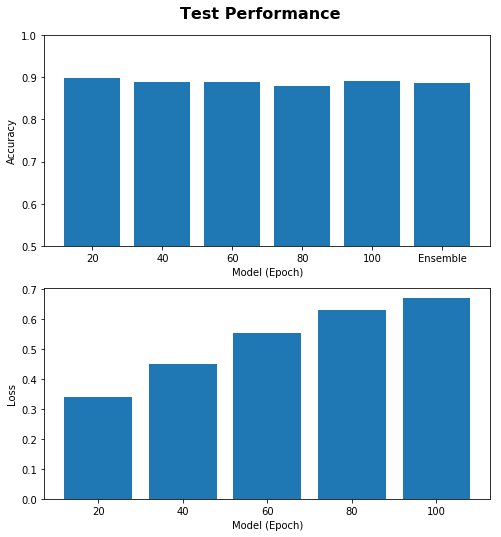

In [143]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 8))
acc_x = np.arange(len(model_scores) + 1)
acc_height = list(model_scores.test_acc.values) + [y_score]
loss_x = np.arange(len(model_scores))
loss_height = list(model_scores.test_loss.values)

ax1.bar(acc_x, acc_height)
ax1.set_ylabel('Accuracy')
ax1.set_ylim(0.5, 1.0)
ax1.set_xticks(acc_x)
ax1.set_xticklabels(['20', '40', '60', '80', '100', 'Ensemble'])
ax1.set_xlabel('Model (Epoch)')

ax2.bar(loss_x, loss_height)
ax2.set_ylabel('Loss')
ax2.set_xticks(loss_x)
ax2.set_xticklabels(['20', '40', '60', '80', '100'])
ax2.set_xlabel('Model (Epoch)')

plt.suptitle('Test Performance', size=16, weight='bold')
plt.subplots_adjust(top=0.93)
plt.savefig(os.path.join(TESTFILES_PATH, 'snapshot_model_perf.png'));

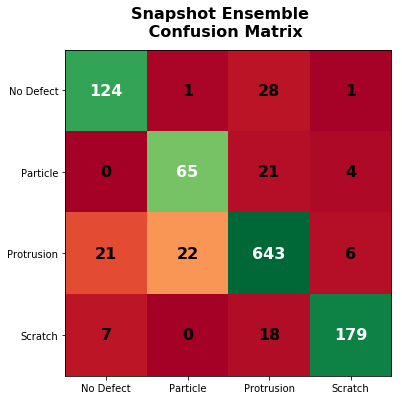

In [145]:
def plot_matrix(confusion_matrix):

    # Normalizing confusion matrix...
    confusion_matrix_norm = confusion_matrix / confusion_matrix.sum(axis=1)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    im = ax.imshow(confusion_matrix_norm, interpolation='nearest', cmap=plt.cm.RdYlGn)
    ax.set_xticks(np.arange(confusion_matrix.shape[0]))
    ax.set_yticks(np.arange(confusion_matrix.shape[0]))
    ax.set_xticklabels(labels.values());
    ax.set_yticklabels(labels.values())

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            correct_coords = reversed([(0, 0), (1, 1), (2, 2), (3, 3)])
            if (i, j) in correct_coords:
                color = 'w'
            else: 
                color = 'k'
            ax.text(j, i, format(confusion_matrix[i, j]), ha='center', va='center',
                    size=16, weight='bold', color=color)
    plt.suptitle('Snapshot Ensemble \n Confusion Matrix', weight='bold', size=16);
plot_matrix(conf_matrix)
plt.savefig(os.path.join(TESTFILES_PATH, 'confmatrix.png'))

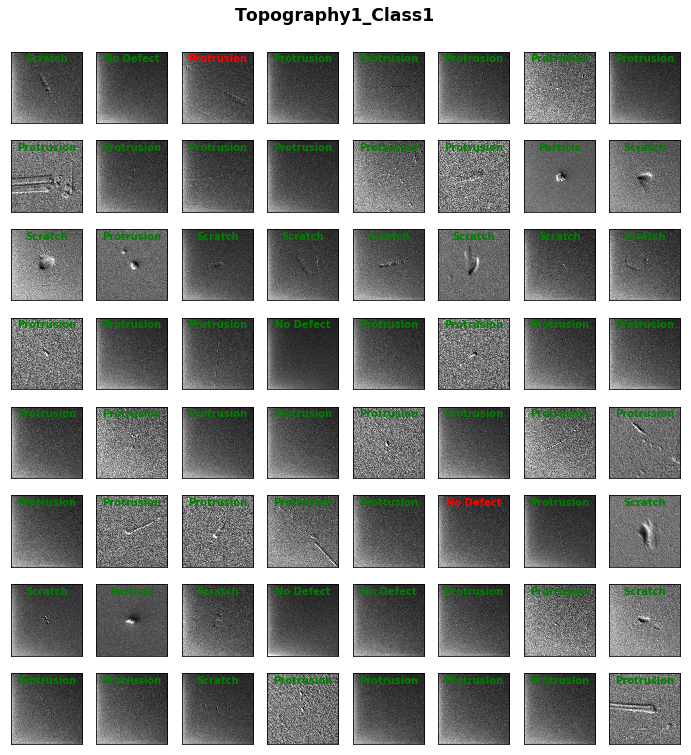

In [142]:
def plot_sample_images(df, y_pred, y_true, image_type='Topography1_Class1', seed=3):
    np.random.seed(seed)
    image_df = df[df.image_type == image_type].drop(columns=df.columns[0:4])
    # masking defect_labels with fewer than 50 images
    defect_counts = image_df.defect_label.value_counts()
    defect_labels = defect_counts[defect_counts > 19].index

#     n_labels = len(defect_labels)
    n_labels = 8
    mx, nx = (250, 250)

    fig, rows = plt.subplots(n_labels, n_labels, figsize=(12, 12))
    
    i_pred = 0
    for i, row in enumerate(rows):
#         label = defect_labels[i]
#         data = image_df[image_df.defect_label == label].reset_index()
        for ax in row:
#             n = np.random.randint(len(data))
            example = df.iloc[i_pred, :]
            im_file = example['image_paths']
            im = Image.open(im_file).resize((mx, nx))
            ax.imshow(im)
            if y_pred[i_pred] == y_true[i_pred]:
                color='green'
            else:
                color='red'
            ax.text(125, 25, y_pred[i_pred], size=10, weight='bold', color=color, va='center', ha='center')
            ax.grid(False)
            ax.set_xticks([])
            ax.set_yticks([])
            i_pred += 1

#     for ax, row in zip(rows[:, 0], defect_labels):
#         ax.set_ylabel(row, size='large', rotation=90)

    plt.suptitle(image_type, size='xx-large', weight='bold')
    plt.subplots_adjust(top=0.93);

plot_sample_images(test_df, predictions, y_test)
plt.savefig(os.path.join(TESTFILES_PATH,'example_pred.png'))